# Getting started with Rockpool

## Importing Rockpool modules

In [1]:
# - Import classes to represent time series data
from rockpool import TimeSeries, TSContinuous, TSEvent

# - Import the `Network` base class
from rockpool import Network

# - Import some `Layer` classes to use
from rockpool.layers import RecRateEuler, PassThrough

WARNING    /anaconda3/envs/py36_tf/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
# - Import numpy
import numpy as np

# - Import the plotting library
import matplotlib.pyplot as plt

## Build a small network
We will define a very small recurrent network, with one input channel, ten recurrent units, and one output channel.

In [3]:
# - Define the network size
input_size = 1
rec_size = 10
output_size = 1

# - Define weights
weights_in = np.random.rand(input_size, rec_size) - .5
weights_rec = np.random.randn(rec_size, rec_size) / rec_size
weights_out = np.random.rand(rec_size, output_size) - .5

# - Construct three layers
lyrInput = PassThrough(weights_in, name = "Input")
lyrRecurrent = RecRateEuler(weights_rec, name = "Recurrent")
lyrOut = PassThrough(weights_out, name = "Output")

# - Compose these into a network
net = Network(lyrInput, lyrRecurrent, lyrOut)

# - Display the network
print(net)

Network object with 3 layers
    PassThrough object: "Input" [1 TSContinuous in -> 10 TSContinuous out]
    RecRateEuler object: "Recurrent" [10 TSContinuous in -> 10 TSContinuous out]
    PassThrough object: "Output" [10 TSContinuous in -> 1 TSContinuous out]


## Define an input signal

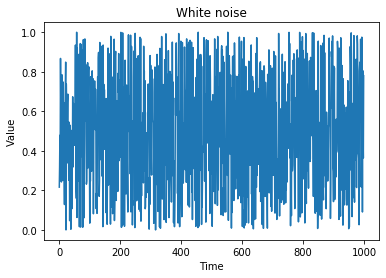

In [4]:
# - Build a time base
timebase = np.arange(1000)

# - Create a white noise time series
ts_white = TSContinuous(timebase, np.random.rand(timebase.size))

# - Plot the time series
ts_white.plot()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('White noise');

## Stimulate the network
Now we can inject the white noise series into the network, and obtain the resulting network activity.

In [5]:
dResponse = net.evolve(ts_white)

Network: Evolving layer `Input` with external input as input
Network: Evolving layer `Recurrent` with Input's output as input
Network: Evolving layer `Output` with Recurrent's output as input


`dResponse` is a dictionary containing the time series produced by the network during evolution. The signals in `dResponse` are named for the layer which produced them:

In [6]:
dResponse

{'external': non-periodic TSContinuous object `unnamed` from t=0.0 to 999.0. Samples: 1000. Channels: 1,
 'Input': non-periodic TSContinuous object `unnamed` from t=0.0 to 999.0. Samples: 1000. Channels: 10,
 'Recurrent': non-periodic TSContinuous object `unnamed` from t=0.0 to 999.0. Samples: 9991. Channels: 10,
 'Output': non-periodic TSContinuous object `unnamed` from t=0.0 to 999.0. Samples: 1000. Channels: 1}

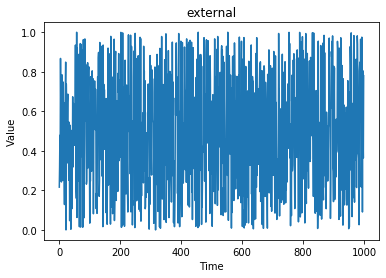

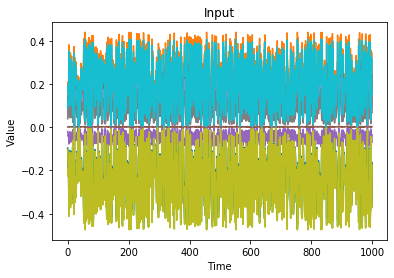

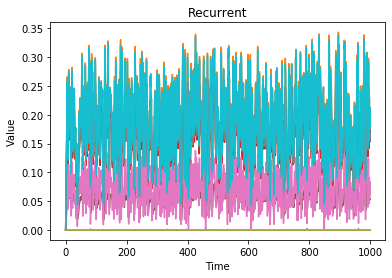

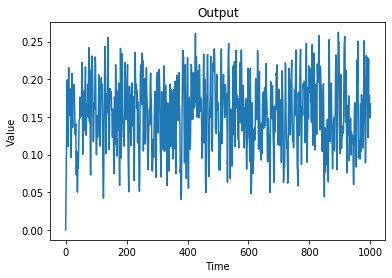

In [7]:
# - Define an auxilliary function to help us with plotting
def plot_signal(k, ts):
    plt.figure()
    ts.plot()
    plt.title(k)
    plt.xlabel('Time')
    plt.ylabel('Value')

# - Plot all the signals in turn
[ plot_signal(k, ts)
    for k, ts in zip(dResponse.keys(), dResponse.values())
];